## load dependencies

In [ ]:
!pip install -r requirements.txt
!pip install -e .

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from PIL import Image
from diffusion_from_scratch.train import DiffusionModel
reverse_xfrm = DiffusionModel.get_reverse_transform()

def image_grid(img_tensors, rows, cols):
    imgs = [reverse_xfrm(tens) for tens in img_tensors]
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## view (linear) noise schedule

In [31]:
import matplotlib.pyplot as plt
from diffusion_from_scratch.train import DiffusionModel

def plot_noise_schedule(dm):
    fig, ax1 = plt.subplots(figsize=(4, 3))
    ax2 = ax1.twinx()
    ax1.plot(torch.sqrt(dm.alpha_hats.cpu()), color="b")
    ax2.plot(torch.sqrt(1 - dm.alpha_hats.cpu()), color="r")
    ax1.set_ylabel(r"${\sqrt{\bar{\alpha}_t}}$", color="b")
    ax2.set_ylabel(r"${\sqrt{1 - \bar{\alpha}_t}}$", color="r")
    plt.show()

def show_image_noising(imgs_tensor, dm):
    # we want x_noisies, a list of tensors (BxCxWxH), one for each timestep
    time_to_tensor = lambda t: (torch.ones(imgs_tensor.shape[0]) * t).long().to(dm.device)
    x_noisies = [
        dm.add_noise_one_step(x, time_to_tensor(timestep))[0]
        for timestep in range(0, dm.t_steps, dm.t_steps // 10)
    ]
    # plot one row for each image
    for i in range(imgs_tensor.shape[0]):
        grid = image_grid(
            [x_noisy[i, :, :, :].detach() for x_noisy in x_noisies],
            rows=1,
            cols=len(x_noisies)
        )
        grid.show()

In [45]:
# get torch tensor for a batch of imgs
dm = DiffusionModel(dataset_path="data/miyazaki")
x, _ = next(iter(dm.get_data()))
x = x[:4, :, :, :].to(dm.device)

schedule from original ddpm paper

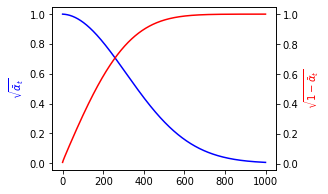

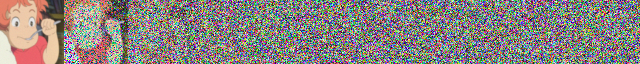

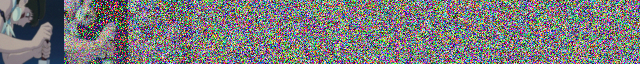

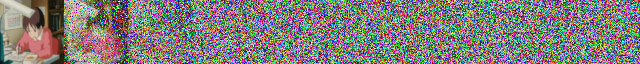

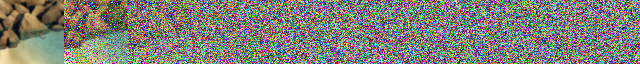

In [32]:
dm = DiffusionModel(t_steps=1000)
plot_noise_schedule(dm)
show_image_noising(x, dm)

blue and red lines indicate proportion of original image and noise, respectively

no discernable structure in the images past a certain point

what happens if we set t_steps lower?

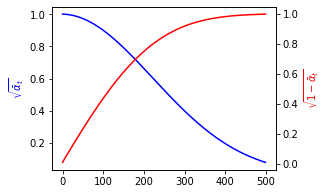

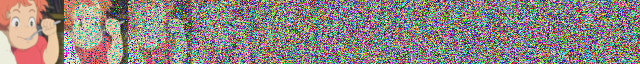

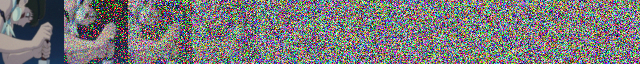

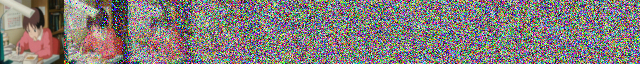

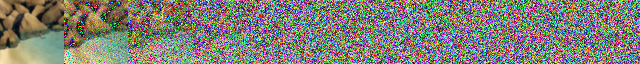

In [33]:
dm = DiffusionModel(t_steps=500)
plot_noise_schedule(dm)
show_image_noising(x, dm)

can pretty cleary see the rational for trying different noise schedules

even for just setting t_steps lower!

## attention-less model
unet from https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

but let's start by leaving attention out

In [ ]:
dm = DiffusionModel(t_steps=1000, epochs=100, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()

### results

999it [00:17, 57.53it/s]


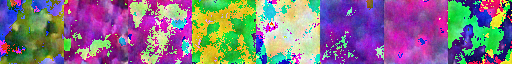

In [52]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=1000)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

yucky

## add attention at res 16 level

In [ ]:
dm = DiffusionModel(t_steps=200, epochs=20, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()

199it [00:03, 55.47it/s]


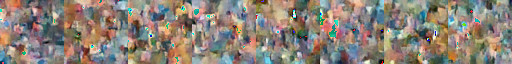

In [54]:
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=200)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

outputs starting to look more structured

let's add attention at all lower resolutions and train for 500 epochs

## train and save full model

In [ ]:
dm = DiffusionModel(t_steps=500, epochs=500, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

### load and check results

In [35]:
# load saved model
from diffusion_from_scratch.unet import UncondUNet
model = UncondUNet()
model.load_state_dict(torch.load("data/model_ckpt.pt"))
dm = DiffusionModel(t_steps=500, dataset_path="data/miyazaki", model=model)

499it [00:09, 52.31it/s]


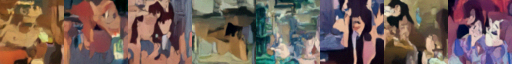

In [43]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=500)
grid = image_grid(x_denoised.clamp(-1, 1), rows=1, cols=len(x_denoised))
grid

now we're starting to see discernable shapes, even faces + hair

not bad with only ~1000 images and no-pretraining!

### model summary

In [34]:
from torchsummary import summary
summary(dm.model)

Layer (type:depth-idx)                                  Param #
├─DoubleConv: 1-1                                       --
|    └─Sequential: 2-1                                  --
|    |    └─Conv2d: 3-1                                 1,728
|    |    └─GroupNorm: 3-2                              128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,864
|    |    └─GroupNorm: 3-5                              128
├─Down: 1-2                                             --
|    └─Sequential: 2-2                                  --
|    |    └─MaxPool2d: 3-6                              --
|    |    └─DoubleConv: 3-7                             73,984
|    |    └─DoubleConv: 3-8                             221,696
|    └─Sequential: 2-3                                  --
|    |    └─SiLU: 3-9                                   --
|    |    └─Linear: 3-10                                16,512
├─SelfAttention: 1-3         

Layer (type:depth-idx)                                  Param #
├─DoubleConv: 1-1                                       --
|    └─Sequential: 2-1                                  --
|    |    └─Conv2d: 3-1                                 1,728
|    |    └─GroupNorm: 3-2                              128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,864
|    |    └─GroupNorm: 3-5                              128
├─Down: 1-2                                             --
|    └─Sequential: 2-2                                  --
|    |    └─MaxPool2d: 3-6                              --
|    |    └─DoubleConv: 3-7                             73,984
|    |    └─DoubleConv: 3-8                             221,696
|    └─Sequential: 2-3                                  --
|    |    └─SiLU: 3-9                                   --
|    |    └─Linear: 3-10                                16,512
├─SelfAttention: 1-3         